Firstly, I make a dataframe from one instance of gpx data from a run to start building the code that will map this geo-spatially. 

In [ ]:
% pip install pandas numpy matplotlib seaborn selenium webdriver-manager geopy requests beautifulsoup4

In [52]:
import xml.etree.ElementTree as ET
import pandas as pd
from geopy.distance import geodesic

# Define GPX file path
gpx_file_path = "skye_strava_data/activities/12111055853.gpx"

# Parse the GPX XML file
tree = ET.parse(gpx_file_path)
root = tree.getroot()

# define the namespace for GPX
ns = {"default": "http://www.topografix.com/GPX/1/1"}

# Extract track points
track_data = []
for trkpt in root.findall(".//default:trkpt", ns):
    lat = float(trkpt.get("lat"))
    lon = float(trkpt.get("lon"))
    ele = float(trkpt.find("default:ele", ns).text)
    time = trkpt.find("default:time", ns).text
    track_data.append((lat, lon, ele, time))
    
#convert to datafrom and convert time to datetime
df = pd.DataFrame(track_data, columns=["Latitude", "Longitude", "Elevation", "Time"])
df["Time"] = pd.to_datetime(df["Time"])

df.head()


,Latitude,Longitude,Elevation,Time
0,51.595759,-0.376236,63.6,2024-08-10 12:38:15+00:00
1,51.595746,-0.376215,63.6,2024-08-10 12:38:16+00:00
2,51.595732,-0.376193,63.6,2024-08-10 12:38:17+00:00
3,51.595719,-0.376172,63.7,2024-08-10 12:38:18+00:00
4,51.595705,-0.376151,63.7,2024-08-10 12:38:19+00:00


In [53]:
## An elementary example of how to calculate distance and speed from GPX data
# Calculate distances between consecutive points
distances = [0]  # First point has no previous point to compare to
for i in range(1, len(df)):
    prev_point = (df.iloc[i - 1]["Latitude"], df.iloc[i - 1]["Longitude"])
    curr_point = (df.iloc[i]["Latitude"], df.iloc[i]["Longitude"])
    distance = geodesic(prev_point, curr_point).meters  # Distance in meters
    distances.append(distance)

df["Distance (m)"] = distances
df["Cumulative Distance (m)"] = df["Distance (m)"].cumsum()

# Calculate time differences
df["Time Diff (s)"] = df["Time"].diff().dt.total_seconds().fillna(0)

# Calculate speed (m/s) and convert to km/h
df["Speed (m/s)"] = df["Distance (m)"] / df["Time Diff (s)"]
df["Speed (km/h)"] = df["Speed (m/s)"] * 3.6  # Convert m/s to km/h

# Calculate pace (minutes per km)
df["Pace (min/km)"] = (1 / df["Speed (km/h)"]) * 60

df.head()

#df.to_csv("processed_run_dataTEST.csv", index=False)


,Latitude,Longitude,Elevation,Time,Distance (m),Cumulative Distance (m),Time Diff (s),Speed (m/s),Speed (km/h),Pace (min/km)
0,51.595759,-0.376236,63.6,2024-08-10 12:38:15+00:00,0.000000,0.000000,0.0,NaN,NaN,NaN
1,51.595746,-0.376215,63.6,2024-08-10 12:38:16+00:00,2.051728,2.051728,1.0,2.051728,7.386222,8.123233
2,51.595732,-0.376193,63.6,2024-08-10 12:38:17+00:00,2.179517,4.231245,1.0,2.179517,7.846260,7.646956
3,51.595719,-0.376172,63.7,2024-08-10 12:38:18+00:00,2.051729,6.282974,1.0,2.051729,7.386224,8.123230
4,51.595705,-0.376151,63.7,2024-08-10 12:38:19+00:00,2.131623,8.414597,1.0,2.131623,7.673844,7.818767


At this point I am experimenting with visualising the data and building a function to plot the data, shown in the simple lat/lon plot below.
 

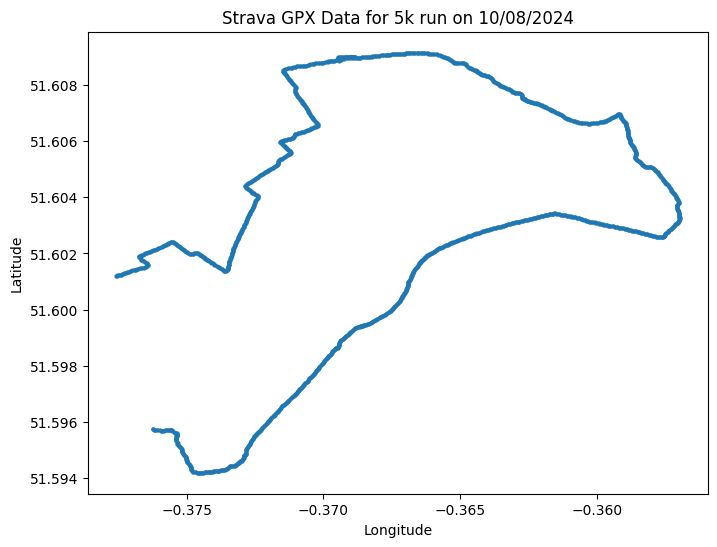

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(df["Longitude"], df["Latitude"], marker="o", linestyle="-", markersize=2)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Strava GPX Data for 5k run on 10/08/2024")
plt.show()


The following code loops through all the gpx files in the directory - each representing a strava activity - and creates a dataframe for each one. It appends each activity to the meta list. 

In [55]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
from geopy.distance import geodesic

# identify the folder containing GPX files
gpx_folder = "skye_strava_data/activities"

# Parsing the GPX files and extracting data
summary_data = []
ns = {"default": "http://www.topografix.com/GPX/1/1"}

for filename in os.listdir(gpx_folder):
    if filename.endswith(".gpx"):
        file_path = os.path.join(gpx_folder, filename)
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Get date
        date_tag = root.find(".//default:time", ns)
        if date_tag is None:
            continue
        date = date_tag.text[:10]

        # Get run name
        name_tag = root.find(".//default:name", ns)
        name = name_tag.text if name_tag is not None else filename

        # Extract points
        points = []
        times = []
        for trkpt in root.findall(".//default:trkpt", ns):
            lat = float(trkpt.get("lat"))
            lon = float(trkpt.get("lon"))
            time = trkpt.find("default:time", ns).text
            points.append((lat, lon))
            times.append(pd.to_datetime(time))

        if len(points) < 2:
            continue

        # Calculate distance and duration
        distance = sum(geodesic(points[i-1], points[i]).km for i in range(1, len(points)))
        duration = (times[-1] - times[0]).total_seconds() / 60

        # Calculate average pace
        avg_pace = duration / distance if distance > 0 else 0
        pace_str = f"{int(avg_pace)}:{int((avg_pace % 1) * 60):02d}"

        # Add to list
        summary_data.append({
            "Filename": filename,
            "Name": name,
            "Date": date,
            "Distance (km)": round(distance, 2),
            "Duration (min)": round(duration, 1),
            "Avg Pace (min/km)": pace_str
        })

# save and display
df_summary = pd.DataFrame(summary_data)
print(df_summary)
#df_summary.to_csv("all_run_summary.csv", index=False)


           Filename                   Name        Date  Distance (km)  \
0   12111055853.gpx                 2nd 5k  2024-08-10           5.03   
1   12152574009.gpx    sheffield river run  2024-08-15           5.72   
2   12230956645.gpx              a bit wet  2024-08-24           5.02   
3   12238486493.gpx       easy cali warmup  2024-08-25           1.76   
4   12246214233.gpx               with dad  2024-08-26           5.02   
5   12296670661.gpx  bloody boiling ft dad  2024-09-01           6.62   
6   12313259437.gpx   wakehams hill sprint  2024-09-03           0.22   
7   12415303984.gpx        run to climbing  2024-09-15           2.82   
8   12448999123.gpx     uni girls run club  2024-09-19           4.12   
9   12549317388.gpx          Afternoon Run  2024-10-01           5.02   
10  12563420745.gpx              Lunch Run  2024-10-03           1.98   
11  12605893440.gpx       wet run to shops  2024-10-08           1.14   
12  12637471964.gpx  illness can’t stop me  2024-10

The following two plots visualise all of my runs in exeter. The first plot is a simple grayscale plot with adjusted alpha to show the density of runs in certain areas. The second plot employs a same structre of code but uses a different colour map and adds a terrain basemap to make it more readable and visually appealing. 

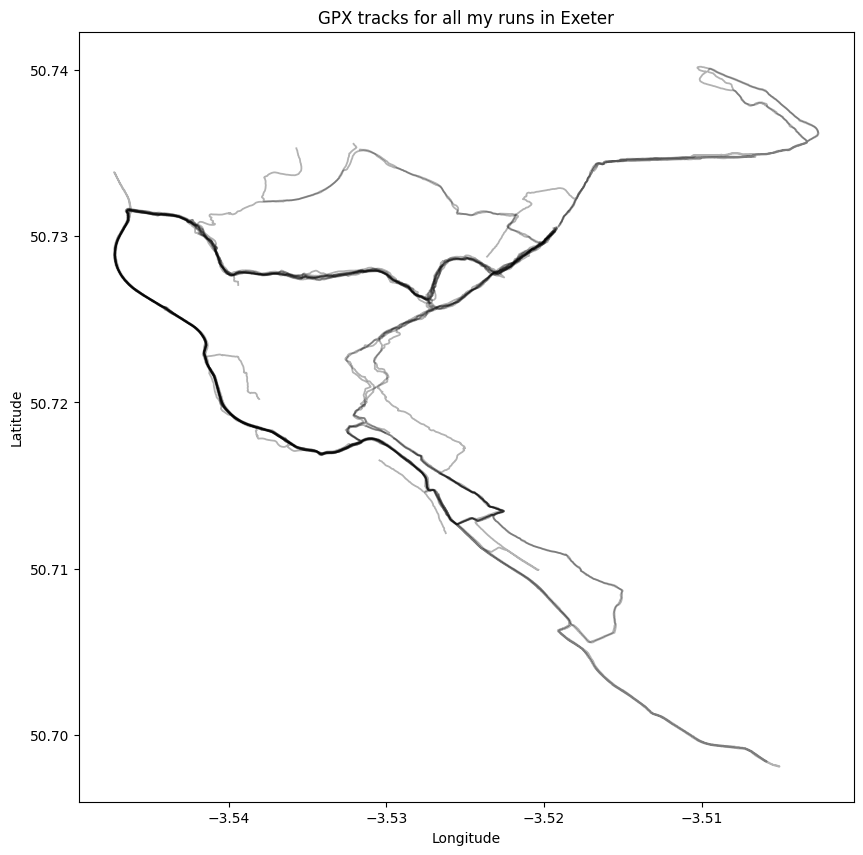

In [56]:

# GPX folder
gpx_folder = "skye_strava_data/activities"

# List of target dates - runs in exeter identified on my Strava account - potential to automate this process in the future
target_dates = [
    "2024-09-09", "2024-09-15", "2024-09-19", "2024-10-01", "2024-10-03", "2024-10-08", "2024-10-12",
    "2024-10-17", "2024-10-22", "2024-11-05", "2024-11-06", "2024-11-14", "2024-11-22", "2024-11-28",
    "2025-01-14", "2025-01-18", "2025-02-18", "2025-02-20", "2025-03-04", "2025-03-05", "2025-03-08",
    "2025-03-18", "2025-03-22", "2025-03-25"
]

ns = {"default": "http://www.topografix.com/GPX/1/1"}

plt.figure(figsize=(10, 10))
plt.title("GPX tracks for all my runs in Exeter")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Loop over files
for filename in os.listdir(gpx_folder):
    if filename.endswith(".gpx"):
        file_path = os.path.join(gpx_folder, filename)
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Get date
        date_tag = root.find(".//default:time", ns)
        if date_tag is None:
            continue  # Skip if no date
        date = date_tag.text[:10]

        if date in target_dates:
            # Extract points
            lats = []
            lons = []
            for trkpt in root.findall(".//default:trkpt", ns):
                lat = float(trkpt.get("lat"))
                lon = float(trkpt.get("lon"))
                lats.append(lat)
                lons.append(lon)

            # Plot
            plt.plot(lons, lats, alpha=0.3, linewidth=1.3, label=date, color="black")

#plt.savefig("all_exeter_runs_mapped_grayscale", dpi=300, bbox_inches="tight")

plt.show()


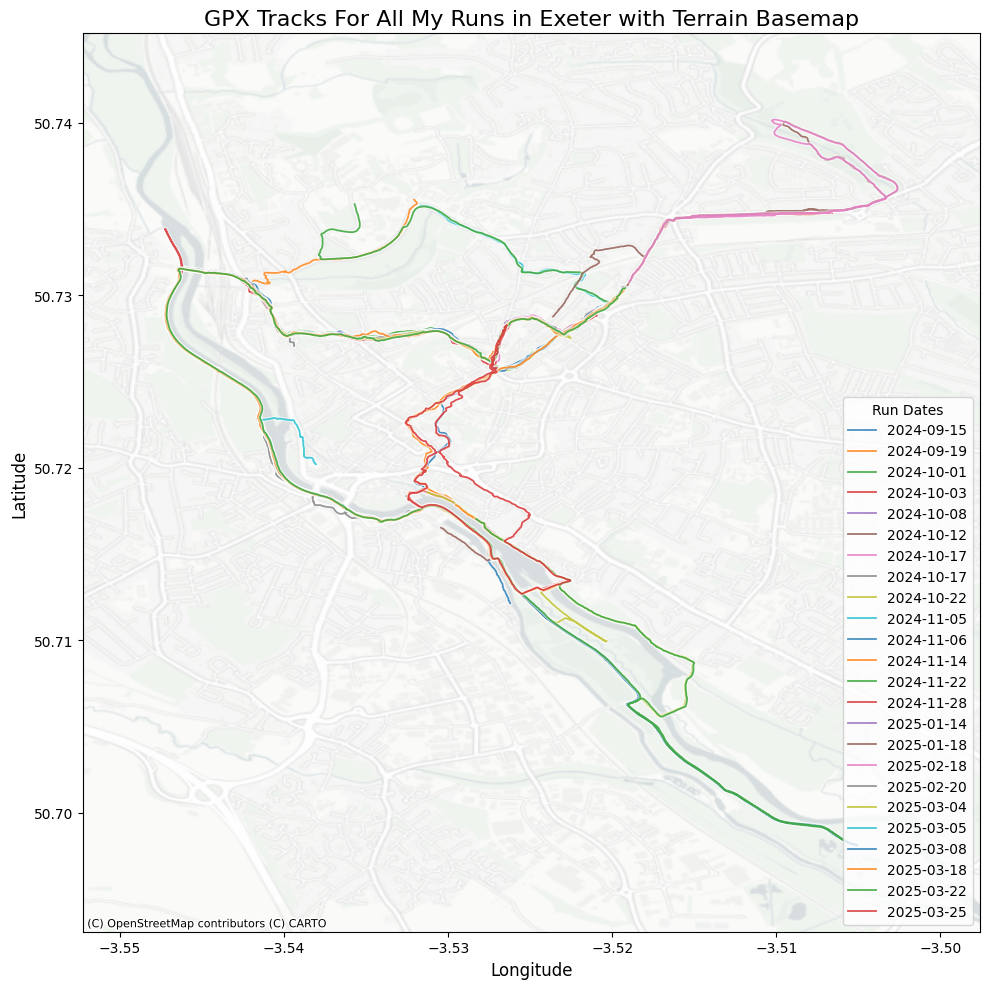

In [57]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import contextily as ctx

#same format as above
gpx_folder = "skye_strava_data/activities"
target_dates = [
    "2024-09-09", "2024-09-15", "2024-09-19", "2024-10-01", "2024-10-03", "2024-10-08", "2024-10-12",
    "2024-10-17", "2024-10-22", "2024-11-05", "2024-11-06", "2024-11-14", "2024-11-22", "2024-11-28",
    "2025-01-14", "2025-01-18", "2025-02-18", "2025-02-20", "2025-03-04", "2025-03-05", "2025-03-08",
    "2025-03-18", "2025-03-22", "2025-03-25"
]
ns = {"default": "http://www.topografix.com/GPX/1/1"}

# Store all route coordinates
all_lats = []
all_lons = []

# Set up the plot
plt.figure(figsize=(10, 10))

# Loop over files
for filename in os.listdir(gpx_folder):
    if filename.endswith(".gpx"):
        file_path = os.path.join(gpx_folder, filename)
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Get date
        date_tag = root.find(".//default:time", ns)
        if date_tag is None:
            continue
        date = date_tag.text[:10]

        if date in target_dates:
            lats = []
            lons = []
            for trkpt in root.findall(".//default:trkpt", ns):
                lat = float(trkpt.get("lat"))
                lon = float(trkpt.get("lon"))
                lats.append(lat)
                lons.append(lon)

            # Plot each route with bold colors and outline
            plt.plot(lons, lats, color="white", linewidth=3, alpha=0.5)  # Outline (halo)
            plt.plot(lons, lats, linewidth=1.3, label=date, alpha=0.8)  # Main route

            all_lats.extend(lats)
            all_lons.extend(lons)

# Basemap - Grayscale map
if all_lats and all_lons:
    xmin, xmax = min(all_lons), max(all_lons)
    ymin, ymax = min(all_lats), max(all_lats)

    plt.xlim(xmin - 0.005, xmax + 0.005)  # Add a bit of padding
    plt.ylim(ymin - 0.005, ymax + 0.005)

    ax = plt.gca()
    ctx.add_basemap(
        ax,
        crs="EPSG:4326",
        source=ctx.providers.CartoDB.PositronNoLabels, 
        alpha=0.9  # Slight transparency to make lines stand out
    )

# Aesthetic adjustments
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.title("GPX Tracks For All My Runs in Exeter with Terrain Basemap", fontsize=16)

plt.legend(fontsize=10, loc="lower right", title="Run Dates")
plt.tight_layout()

#plt.savefig("all_exeter_runs_mapped_colour", dpi=300, bbox_inches="tight")

plt.show()



Plotting average pace on a map, with lots of trial and error in use of bins to make segments where average speeds are calculated so it is visually smooth. 


C:\Users\leath\AppData\Local\Temp\ipykernel_19388\3526903856.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("plasma_r")  # Reversed plasma: faster = darker, slower = lighter


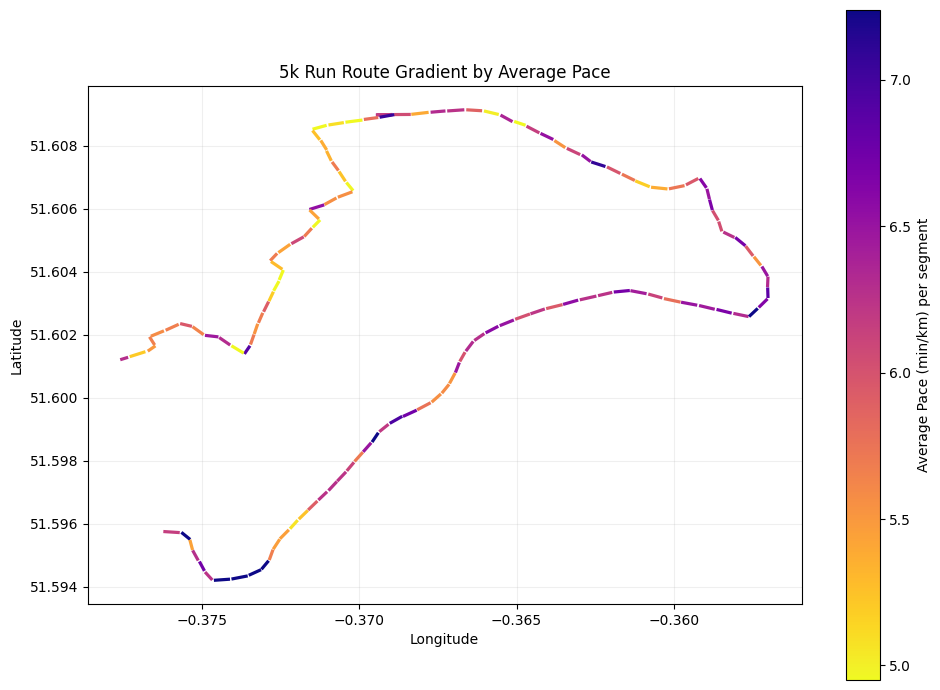

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap

# load the processed data
df = pd.read_csv("processed_run_dataTEST.csv")
df = df.dropna(subset=["Latitude", "Longitude", "Speed (m/s)"])
df = df[df["Speed (m/s)"] > 0]

# calculate distances and cumulative distances
distances = [0]
for i in range(1, len(df)):
    prev = (df.iloc[i-1]["Latitude"], df.iloc[i-1]["Longitude"])
    curr = (df.iloc[i]["Latitude"], df.iloc[i]["Longitude"])
    dist = geodesic(prev, curr).meters
    distances.append(dist)
df["Distance (m)"] = distances
df["Cumulative Distance (m)"] = df["Distance (m)"].cumsum()

# Binning the data - lots of testing here
bin_size = 40  # 40 meters per bin
df["Bin"] = (df["Cumulative Distance (m)"] // bin_size).astype(int)

# create segments and calculate average pace for each bin
segments = []
avg_paces = []

for bin_id, group in df.groupby("Bin"):
    if len(group) < 2:
        continue

    start = (group.iloc[0]["Longitude"], group.iloc[0]["Latitude"])
    end = (group.iloc[-1]["Longitude"], group.iloc[-1]["Latitude"])

    avg_speed = group["Speed (m/s)"].mean()
    avg_pace = (1000 / avg_speed) / 60  # min/km

    segments.append([start, end])
    avg_paces.append(avg_pace)

segments = np.array(segments)

# normalising the average paces for color mapping
vmin = np.percentile(avg_paces, 5)
vmax = np.percentile(avg_paces, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = get_cmap("plasma_r")  # Reversed plasma: faster = darker, slower = lighter

# creating line collection
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(np.array(avg_paces))
lc.set_linewidth(2.3)

# plotting and more aesthetic adjustments
fig, ax = plt.subplots(figsize=(10, 7))
ax.add_collection(lc)
ax.scatter(df["Longitude"], df["Latitude"], color="white", s=1, alpha=0.7)

cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label("Average Pace (min/km) per segment")

ax.set_title("5k Run Route Gradient by Average Pace")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')
ax.grid(True, alpha=0.2)
plt.tight_layout()
#plt.savefig("5k_run_gradient_by_average_pace.png", dpi=300, bbox_inches="tight")
plt.show()


Using CSV 'activities' from issy_strava_data and skye_strava_data - it is an array with information about each activity recorded. 


In [59]:

issy_activities_df = pd.read_csv("issy_strava_data/activities.csv")
issy_activities_df.head()

skye_activities_df = pd.read_csv("skye_strava_data/activities.csv")
#skye_activities_df.head()
issy_activities_df.head()   

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,Activity Count,Total Steps,Carbon Saved,Pool Length,Training Load,Intensity,Average Grade Adjusted Pace,Timer Time,Total Cycles,Media
0,6422476991,"24 Dec 2021, 14:11:29",Afternoon Run,Run,NaN,325,0.57,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6433719220,"24 Dec 2021, 14:18:58",Afternoon Run,Run,NaN,260918,0.2,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6433794819,"27 Dec 2021, 14:47:43",Afternoon Run,Run,NaN,965,1.54,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6433898857,"27 Dec 2021, 15:04:14",Afternoon Run,Run,NaN,1284,2.6,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6451441446,"31 Dec 2021, 13:58:12",Afternoon Run,Run,NaN,559,1.52,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Issy has many more activities recorded than me so I thought it would be interesting to see which activities are her favourite. 

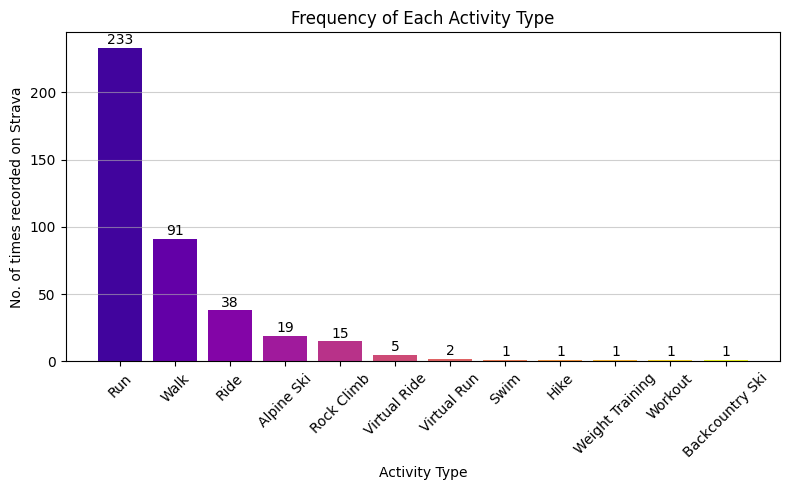

In [60]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Count the number of occurrences of each activity type
activity_counts = issy_activities_df["Activity Type"].value_counts()

plt.figure(figsize=(8, 5))
colors = cm.plasma(np.linspace(0.1, 1, len(activity_counts)))
bars = plt.bar(activity_counts.index, activity_counts.values, color=colors)

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{int(height)}", 
             ha='center', va='bottom', fontsize=10)

plt.title("Frequency of Each Activity Type")
plt.xlabel("Activity Type")
plt.ylabel("No. of times recorded on Strava")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.6)
plt.tight_layout()

#plt.savefig("activity_freq_issy.png", dpi=300, bbox_inches="tight")
plt.show()




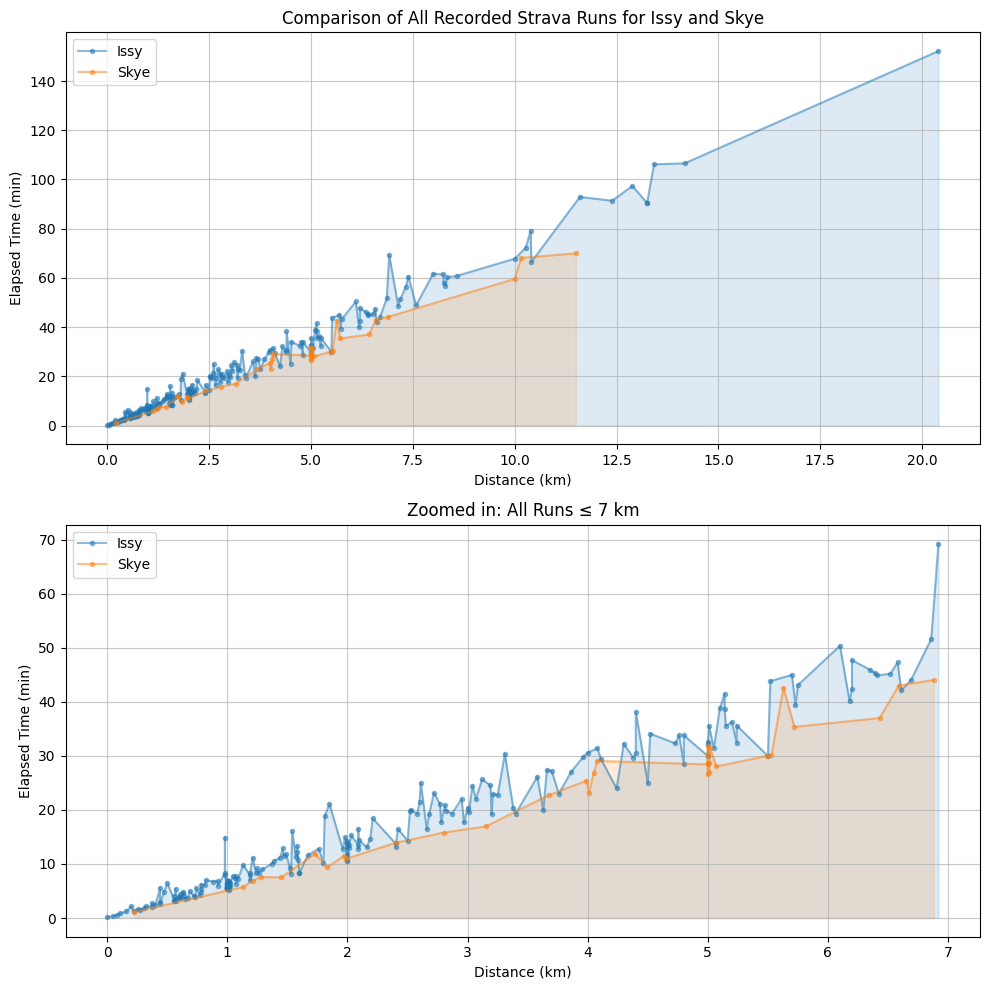

In [61]:

# Filter both dataframes to only include runs
issy_runs = issy_activities_df[issy_activities_df["Activity Type"] == "Run"]
skye_runs = skye_activities_df[skye_activities_df["Activity Type"] == "Run"]

# Remove anomaly to clean data
issy_runs = issy_runs[issy_runs["Elapsed Time"] != 260918].reset_index(drop=True)

# Clean distance values and convert to float
issy_runs["Distance"] = issy_runs["Distance"].astype(str).str.replace("'", "").astype(float)
skye_runs["Distance"] = skye_runs["Distance"].astype(str).str.replace("'", "").astype(float)
# Convert Elapsed Time from seconds to minutes
issy_runs["Elapsed Time"] = issy_runs["Elapsed Time"] / 60
skye_runs["Elapsed Time"] = skye_runs["Elapsed Time"] / 60

# Sorting numerical valyes for plotting
issy_runs = issy_runs.sort_values("Distance")
skye_runs = skye_runs.sort_values("Distance")

# Create stacked plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))  # <- changed to (2, 1)

# Making the first plot that shows full range of distances
ax1.plot(issy_runs["Distance"], issy_runs["Elapsed Time"], label="Issy", color="tab:blue", alpha=0.5, marker='.')
ax1.plot(skye_runs["Distance"], skye_runs["Elapsed Time"], label="Skye", color="tab:orange", alpha=0.5, marker='.')
ax1.fill_between(issy_runs["Distance"], issy_runs["Elapsed Time"], alpha=0.15, color="tab:blue")
ax1.fill_between(skye_runs["Distance"], skye_runs["Elapsed Time"], alpha=0.15, color="tab:orange")
ax1.set_title("Comparison of All Recorded Strava Runs for Issy and Skye")
ax1.set_xlabel("Distance (km)")
ax1.set_ylabel("Elapsed Time (min)")
ax1.grid(True, alpha=0.7)
ax1.legend()

# Plotting second subplot that shows a zoomed-in view of runs less than 7km
issy_short = issy_runs[issy_runs["Distance"] <= 7]
skye_short = skye_runs[skye_runs["Distance"] <= 7]

ax2.plot(issy_short["Distance"], issy_short["Elapsed Time"], label="Issy", color="tab:blue", alpha=0.5, marker='.')
ax2.plot(skye_short["Distance"], skye_short["Elapsed Time"], label="Skye", color="tab:orange", alpha=0.5, marker='.')
ax2.fill_between(issy_short["Distance"], issy_short["Elapsed Time"], alpha=0.15, color="tab:blue")
ax2.fill_between(skye_short["Distance"], skye_short["Elapsed Time"], alpha=0.15, color="tab:orange")
ax2.set_title("Zoomed in: All Runs ≤ 7 km")
ax2.set_xlabel("Distance (km)")
ax2.set_ylabel("Elapsed Time (min)")
ax2.grid(True, alpha=0.7)
ax2.legend()

plt.tight_layout()
#plt.savefig("issy_skye_run-comparison.png", dpi=300, bbox_inches="tight")
plt.show()

        
